# 헬스케어응용SW Project
## Task: 건강검진 데이터를 사용한 고혈압 예측
### 디지털헬스케어학부 2021247024 이정우


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from xgboost import XGBClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from tqdm import tqdm
import numpy as np
from sklearn.metrics import precision_score

## Data load

In [8]:
# Data load
file_path = 'data/Data_20221231_eng.csv'
df = pd.read_csv(file_path, encoding='cp949')

## Preprocessing

In [9]:
df = df.dropna(subset=['systolic_blood_pressure', 'diastolic_blood_pressure'])
df['high_blood_pressure'] = ((df['systolic_blood_pressure'] >= 140) & (df['diastolic_blood_pressure'] >= 90)).astype(int)

# 새로운 변수 생성
df['BMI'] = df['weight'] / ((df['height'] / 100) ** 2)
df['pulse_pressure'] = df['systolic_blood_pressure'] - df['diastolic_blood_pressure']
df['waist_height_ratio'] = df['waist'] / df['height']
df['chol_HDL_ratio'] = df['total_cholesterol'] / df['HDL']
df['LDL_HDL_ratio'] = df['LDL'] / df['HDL']
df['liver_index'] = df['AST'] + df['ALT'] + df['gamma_gtp']
df['smoking_drinking_interaction'] = df['smoking'] * df['drinking']

In [10]:
# Drop unnecessary columns
columns_to_drop = ['year', 'id', 'dental_caries', 'oral_examination', 'tartar', 'systolic_blood_pressure', 'diastolic_blood_pressure']
df = df.drop(columns=columns_to_drop)

print(df.isnull().sum())

iter_imputer = IterativeImputer(random_state=42)
df_iter_imputed = iter_imputer.fit_transform(df)

# Iterative Imputer로 대체된 데이터를 데이터프레임으로 변환
df_iter = pd.DataFrame(df_iter_imputed, columns=df.columns)

# Print missing values count after Iterative Imputation
print("Missing values after Iterative Imputation:")
print(df_iter.isnull().sum())
df = df_iter

area                                 0
sex                                  0
age                                  0
height                               0
weight                               0
waist                              392
eye(left)                          178
eye(right)                         177
ear(left)                          114
ear(right)                         115
fasting_blood_sugar                 76
total_cholesterol               648833
triglyceride                    648837
HDL                             648837
LDL                             655377
hemoglobin                          81
urine_protein                     5519
serum_creatinine                    80
AST                                 78
ALT                                 78
gamma_gtp                           76
smoking                             96
drinking                            73
high_blood_pressure                  0
BMI                                  0
pulse_pressure           

/Users/jwlee/anaconda3/envs/torch/lib/python3.9/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [13]:
# '고혈압' 열을 제외한 나머지 열들을 스케일링
features_to_scale = df.drop('high_blood_pressure', axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_scale)

# 스케일링한 결과를 데이터프레임으로 변환
df_scaled = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# '고혈압' 열을 다시 추가
df_scaled['high_blood_pressure'] = df['high_blood_pressure'].values

# Split data
X = df_scaled.drop('high_blood_pressure', axis=1)
y = df_scaled['high_blood_pressure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

smote_enn = SMOTEENN(random_state=42)
X_train_res, y_train_res = smote_enn.fit_resample(X_train, y_train)
print("SMOTEENN dataset shape:", y_train_res.value_counts())

SMOTEENN dataset shape: 1.0    750429
0.0    543710
Name: high_blood_pressure, dtype: int64


## Train

In [14]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9180497664526445
[[175295  12531]
 [  3768   7295]]
              precision    recall  f1-score   support

         0.0       0.98      0.93      0.96    187826
         1.0       0.37      0.66      0.47     11063

    accuracy                           0.92    198889
   macro avg       0.67      0.80      0.71    198889
weighted avg       0.94      0.92      0.93    198889



## Visualization

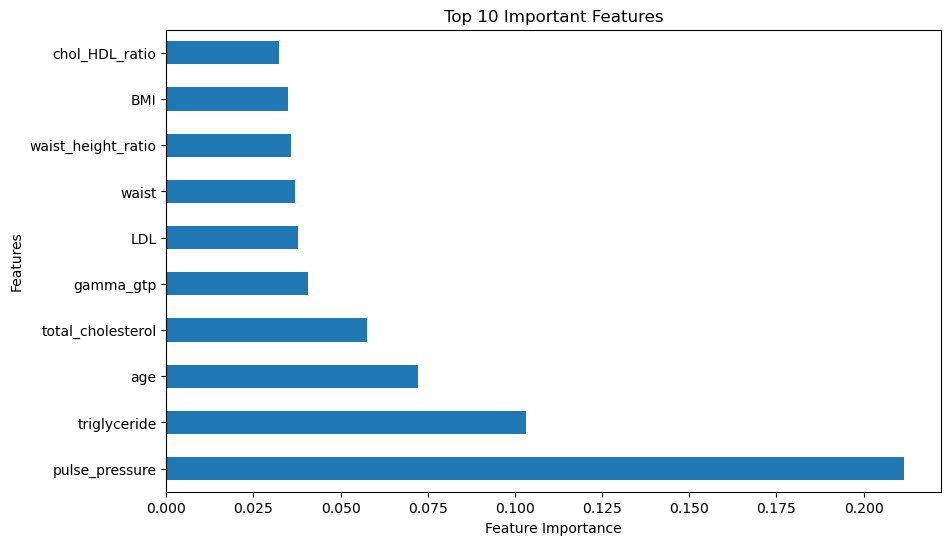

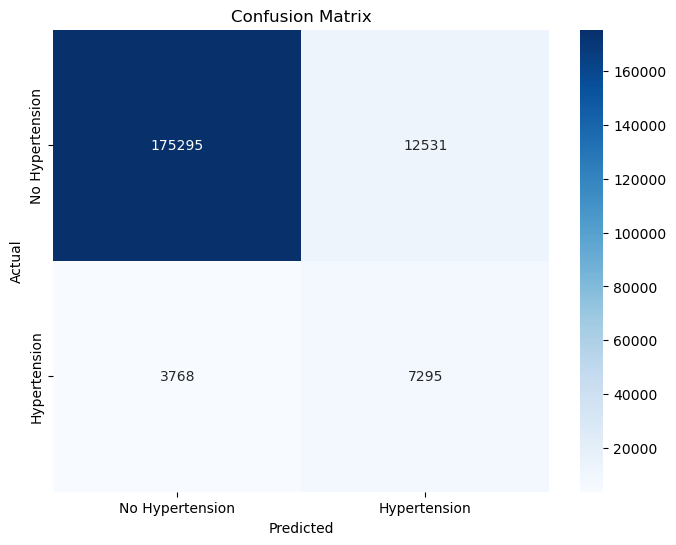

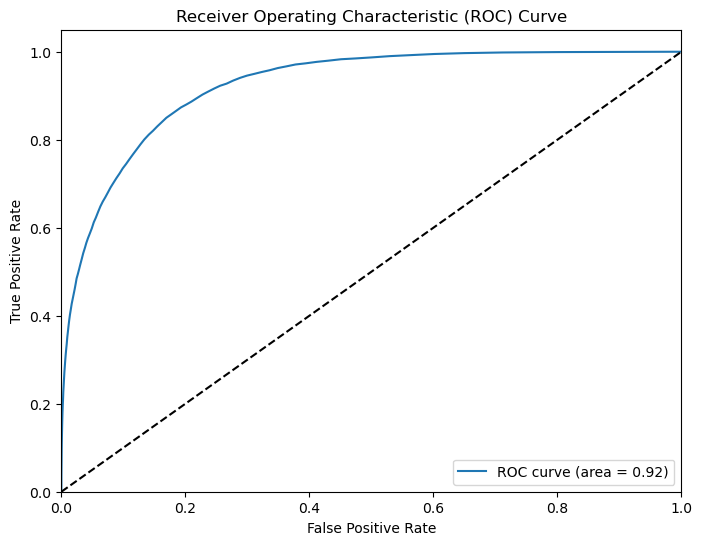

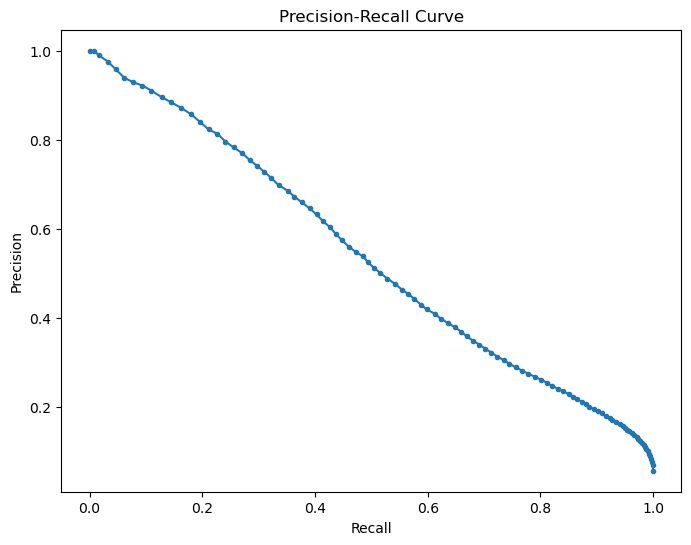

In [19]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# 1. 특성 중요도
feature_importances = pd.Series(model.feature_importances_, index=X.columns)
plt.figure(figsize=(10, 6))
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Hypertension', 'Hypertension'], yticklabels=['No Hypertension', 'Hypertension'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# 3. ROC 곡선
y_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# 4. Precision-Recall 곡선 
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()